# AI-Powered Customer Segmentation Analysis

This notebook demonstrates the use of artificial intelligence for customer segmentation in a data pipeline.

## Table of Contents
1. [Setup and Data Generation](#setup)
2. [Exploratory Data Analysis](#eda)
3. [Data Preprocessing](#preprocessing)
4. [AI-Based Segmentation](#segmentation)
5. [Segment Analysis and Visualization](#analysis)
6. [Business Insights](#insights)

## 1. Setup and Data Generation {#setup}

In [1]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add src to path
sys.path.append('../src')

# Import our custom modules
from data_ingestion.data_generator import CustomerDataGenerator
from preprocessing.data_cleaner import DataCleaner
from segmentation.clustering_model import ClusteringModel
from visualization.segment_visualizer import SegmentVisualizer
from pipeline.pipeline_config import PipelineConfig

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Generate synthetic customer data
data_generator = CustomerDataGenerator(random_seed=42)
raw_data = data_generator.generate_customer_data(n_customers=5000, include_noise=True)

print(f"Generated data shape: {raw_data.shape}")
print(f"Columns: {list(raw_data.columns)}")

Generated data shape: (5000, 23)
Columns: ['customer_id', 'age', 'income', 'region', 'purchase_frequency', 'avg_order_value', 'customer_lifetime', 'total_spend', 'website_visits', 'email_open_rate', 'app_usage', 'electronics_spend_pct', 'clothing_spend_pct', 'home_spend_pct', 'summer_boost', 'holiday_boost', 'recency', 'satisfaction_score', 'support_tickets', 'customer_value_score', 'engagement_score', 'risk_score', 'seasonality_index']


## 2. Exploratory Data Analysis {#eda}

In [3]:
# Display basic information about the dataset
raw_data.head()

,customer_id,age,income,region,purchase_frequency,avg_order_value,customer_lifetime,total_spend,website_visits,email_open_rate,...,home_spend_pct,summer_boost,holiday_boost,recency,satisfaction_score,support_tickets,customer_value_score,engagement_score,risk_score,seasonality_index
0,CUST_000000,50.503304,28445.053435,South,1.853589,103.452870,8.464693,154.457511,7.396451,0.186671,...,0.120056,0.872647,1.533331,-1.577502,6.338479,1.879318,0.236429,0.473995,0.272274,1.269057
1,CUST_000001,36.034050,29736.468198,North,6.176426,118.499348,33.351852,1946.507284,7.295999,0.360589,...,0.249386,0.790903,1.303546,7.223286,8.315226,1.154127,0.487954,0.506966,0.144655,1.098489
2,CUST_000002,47.565213,16922.579334,North,4.946629,100.515933,19.952447,953.649450,8.882440,0.089786,...,0.077157,1.259874,1.479776,59.380824,9.316995,4.870957,0.434882,0.481580,0.353412,1.391815
3,CUST_000003,63.184234,29963.890508,North,7.106671,116.263673,27.906310,1908.474709,16.228142,0.039318,...,0.258520,1.134871,1.577097,23.317593,5.413630,1.933251,0.417327,0.601486,0.312879,1.400207
4,CUST_000004,35.924224,51235.930865,East,4.294733,109.586688,11.114592,541.406537,12.156683,0.436202,...,0.067405,1.283681,1.538640,28.780749,6.517034,-0.246402,0.313535,0.637408,0.122823,1.436656


In [4]:
# Data summary statistics
raw_data.describe()

,age,income,purchase_frequency,avg_order_value,customer_lifetime,total_spend,website_visits,email_open_rate,app_usage,electronics_spend_pct,...,home_spend_pct,summer_boost,holiday_boost,recency,satisfaction_score,support_tickets,customer_value_score,engagement_score,risk_score,seasonality_index
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4761.000000,4753.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,4723.000000,5000.000000,4723.000000,5000.000000,5000.000000,5000.000000
mean,40.052354,41520.394541,5.017416,100.195145,21.504769,902.284729,10.035265,0.286913,0.601516,0.283433,...,0.281356,0.999170,1.496171,29.995912,6.701237,2.031428,0.354213,0.417708,0.271717,1.297371
std,13.971853,21750.213531,2.241173,14.190649,18.476742,956.802386,3.138415,0.159669,0.491515,0.142903,...,0.145922,0.202551,0.298621,30.191225,1.736936,1.425820,0.100018,0.165069,0.116949,0.195084
min,13.750385,12559.261165,-0.400537,58.579739,-3.415798,-316.906797,1.515538,-0.014546,-0.216185,-0.017826,...,-0.027623,0.311705,0.374392,-10.440744,0.739885,-0.416322,0.088787,0.057559,-0.000599,0.598491
25%,29.200269,25680.991650,3.311635,90.201896,6.558802,213.837783,7.844528,0.162084,0.019327,0.174061,...,0.171366,0.860704,1.292677,8.646769,5.562785,0.979584,0.288201,0.259073,0.188185,1.166666
50%,39.738389,35889.683303,4.935670,99.402810,15.943621,582.176313,9.897835,0.264555,0.952768,0.274496,...,0.266895,0.997656,1.497470,21.429937,6.849446,1.959034,0.344673,0.461567,0.263088,1.297328
75%,49.425301,50984.303217,6.289087,109.426614,32.665228,1283.719892,12.102874,0.391748,1.010518,0.377949,...,0.377614,1.142843,1.695555,41.105363,8.063998,2.984302,0.408848,0.554372,0.347002,1.426693
max,82.489246,202389.297548,14.955951,152.440153,66.590936,6793.784060,24.445213,0.896342,1.169844,0.822971,...,0.838389,1.750610,2.772042,233.592766,10.150992,8.962419,0.901923,0.796261,0.790097,2.044484


In [21]:
# Check for missing values
missing_values = raw_data.isnull().sum()
missing_pct = (missing_values / len(raw_data)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_pct
})

missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

,Missing Count,Missing Percentage
customer_value_score,277,5.54
satisfaction_score,277,5.54
app_usage,247,4.94
email_open_rate,239,4.78


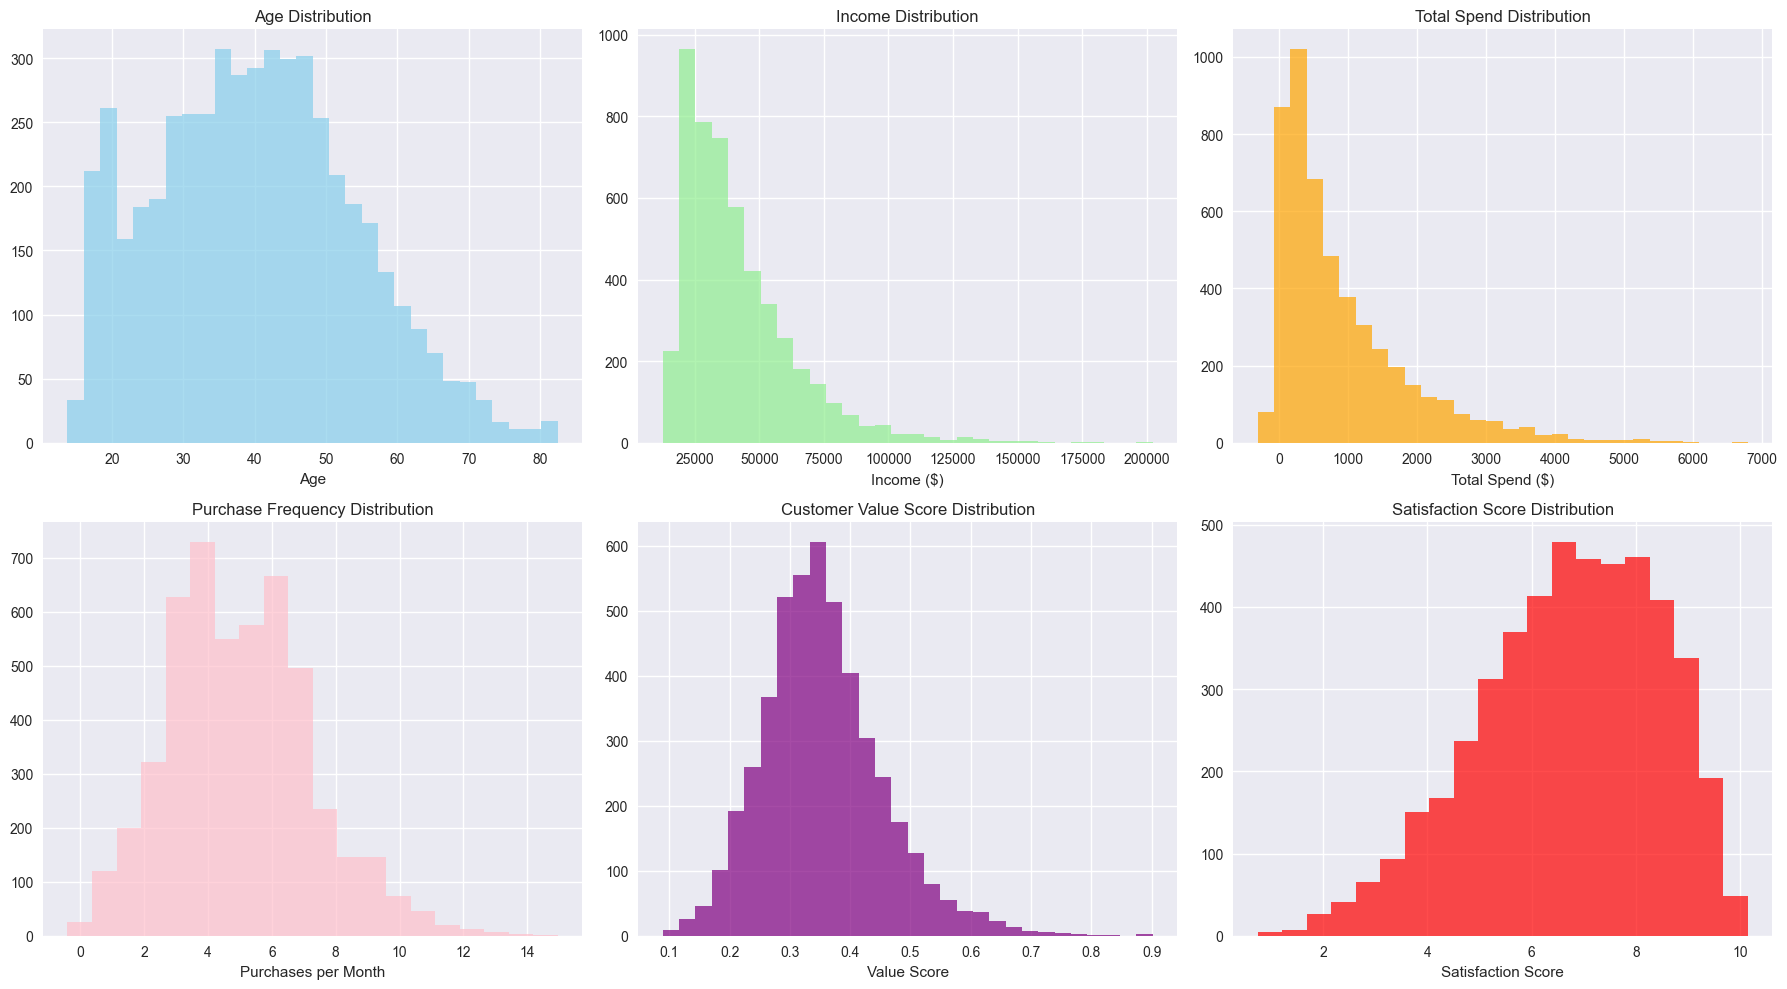

In [22]:
# Visualize key distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age distribution
axes[0, 0].hist(raw_data['age'], bins=30, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Age Distribution')
axes[0, 0].set_xlabel('Age')

# Income distribution
axes[0, 1].hist(raw_data['income'], bins=30, alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Income Distribution')
axes[0, 1].set_xlabel('Income ($)')

# Total spend distribution
axes[0, 2].hist(raw_data['total_spend'], bins=30, alpha=0.7, color='orange')
axes[0, 2].set_title('Total Spend Distribution')
axes[0, 2].set_xlabel('Total Spend ($)')

# Purchase frequency
axes[1, 0].hist(raw_data['purchase_frequency'], bins=20, alpha=0.7, color='pink')
axes[1, 0].set_title('Purchase Frequency Distribution')
axes[1, 0].set_xlabel('Purchases per Month')

# Customer value score
axes[1, 1].hist(raw_data['customer_value_score'], bins=30, alpha=0.7, color='purple')
axes[1, 1].set_title('Customer Value Score Distribution')
axes[1, 1].set_xlabel('Value Score')

# Satisfaction score
axes[1, 2].hist(raw_data['satisfaction_score'].dropna(), bins=20, alpha=0.7, color='red')
axes[1, 2].set_title('Satisfaction Score Distribution')
axes[1, 2].set_xlabel('Satisfaction Score')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing {#preprocessing}

In [5]:
# Initialize data cleaner and clean the data
data_cleaner = DataCleaner()

# Configuration for data cleaning
cleaning_config = {
    'remove_outliers': True,
    'outlier_method': 'iqr',
    'outlier_threshold': 1.5,
    'fill_missing': True,
    'missing_strategy': 'median',
    'normalize_features': True,
    'normalization_method': 'standard'
}

# Clean the data
processed_data = data_cleaner.clean_data(raw_data, cleaning_config)

print(f"Original data shape: {raw_data.shape}")
print(f"Processed data shape: {processed_data.shape}")

Original data shape: (5000, 23)
Processed data shape: (3951, 23)


In [7]:
# Select features for clustering
feature_columns = [
    'age', 'income', 'total_spend', 'avg_order_value', 'purchase_frequency',
    'website_visits', 'email_open_rate', 'customer_value_score', 'engagement_score',
    'risk_score', 'seasonality_index', 'recency'
]

# Filter available features
available_features = [col for col in feature_columns if col in processed_data.columns]
feature_data = processed_data[available_features]

print(f"Selected {len(available_features)} features for clustering:")
print(available_features)

Selected 12 features for clustering:
['age', 'income', 'total_spend', 'avg_order_value', 'purchase_frequency', 'website_visits', 'email_open_rate', 'customer_value_score', 'engagement_score', 'risk_score', 'seasonality_index', 'recency']


## 4. AI-Based Segmentation {#segmentation}

In [8]:
# Initialize clustering model
clustering_model = ClusteringModel()

# Find optimal number of clusters
optimal_k, optimization_metrics = clustering_model.find_optimal_clusters(
    feature_data, method='kmeans', max_clusters=8, min_clusters=2
)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {optimization_metrics['silhouette_scores'][optimal_k-2]:.3f}")

Optimal number of clusters: 2
Best silhouette score: 0.112


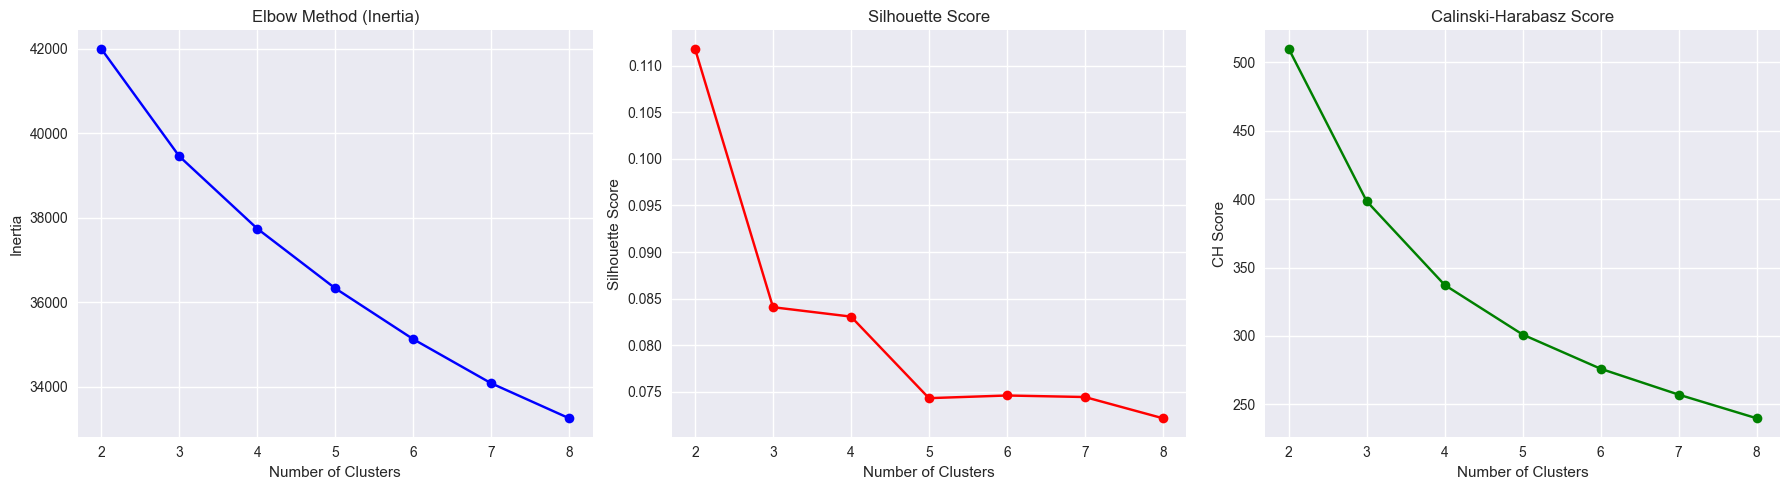

In [10]:
# Visualize optimization metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cluster_range = optimization_metrics['cluster_range']

# Elbow curve (Inertia)
axes[0].plot(cluster_range, optimization_metrics['inertias'], 'bo-')
axes[0].set_title('Elbow Method (Inertia)')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].grid(True)

# Silhouette scores
axes[1].plot(cluster_range, optimization_metrics['silhouette_scores'], 'ro-')
axes[1].set_title('Silhouette Score')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

# Calinski-Harabasz scores
axes[2].plot(cluster_range, optimization_metrics['calinski_scores'], 'go-')
axes[2].set_title('Calinski-Harabasz Score')
axes[2].set_xlabel('Number of Clusters')
axes[2].set_ylabel('CH Score')
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Perform K-means clustering with optimal number of clusters
cluster_labels = clustering_model.fit_kmeans(feature_data, n_clusters=optimal_k, random_state=42)

print(f"Clustering completed!")
print(f"Number of segments: {len(set(cluster_labels))}")
print(f"Silhouette score: {clustering_model.metrics['silhouette_score']:.3f}")

# Add cluster labels to processed data (matches cluster labels length)
segmented_data = processed_data.copy()
segmented_data['segment'] = cluster_labels

print(f"\nSegmented data shape: {segmented_data.shape}")
print(f"Cluster labels shape: {len(cluster_labels)}")

Clustering completed!
Number of segments: 2
Silhouette score: 0.112

Segmented data shape: (3951, 24)
Cluster labels shape: 3951


## 5. Segment Analysis and Visualization {#analysis}

In [14]:
# Display segment sizes
segment_counts = pd.Series(cluster_labels).value_counts().sort_index()
segment_percentages = (segment_counts / len(cluster_labels) * 100).round(1)

segment_summary = pd.DataFrame({
    'Segment': [f'Segment {i}' for i in segment_counts.index],
    'Count': segment_counts.values,
    'Percentage': segment_percentages.values
})

print("Segment Distribution:")
print(segment_summary)

Segment Distribution:
     Segment  Count  Percentage
0  Segment 0   1599        40.5
1  Segment 1   2352        59.5


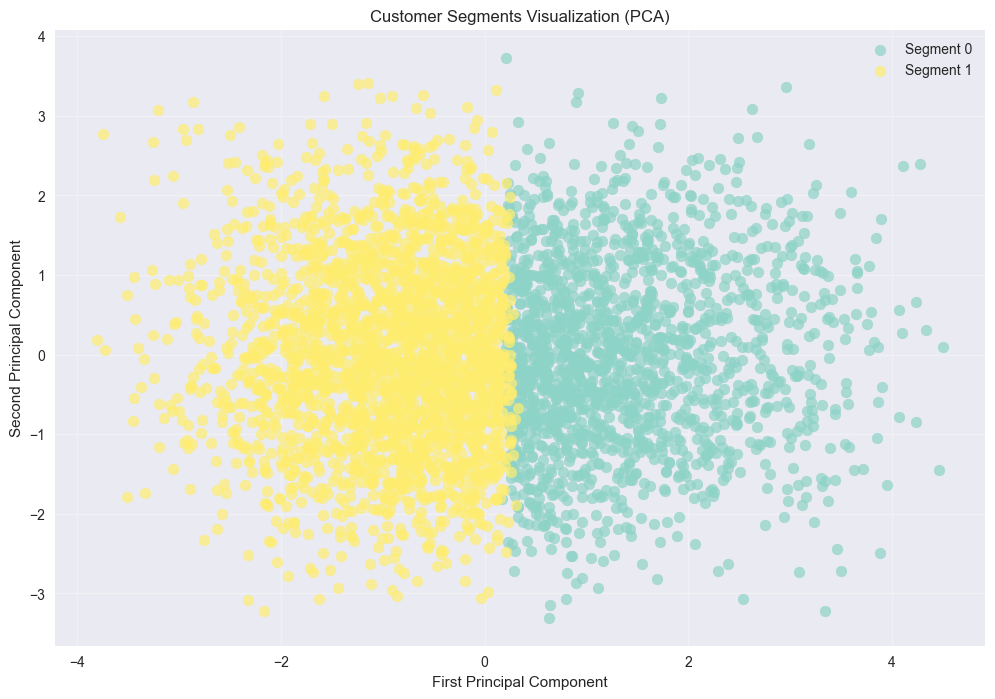

PCA explained variance: 0.290


In [15]:
# Create 2D visualization using PCA
data_2d = clustering_model.reduce_dimensions_for_visualization(feature_data, n_components=2)

plt.figure(figsize=(12, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(set(cluster_labels))))

for i, label in enumerate(sorted(set(cluster_labels))):
    mask = cluster_labels == label
    plt.scatter(data_2d[mask, 0], data_2d[mask, 1], 
               c=[colors[i]], s=60, alpha=0.7, label=f'Segment {label}')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments Visualization (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"PCA explained variance: {clustering_model.pca.explained_variance_ratio_.sum():.3f}")

In [18]:
# Analyze segment characteristics
segment_profiles = segmented_data.groupby('segment').agg({
    'age': 'mean',
    'income': 'mean',
    'total_spend': 'mean',
    'avg_order_value': 'mean',
    'purchase_frequency': 'mean',
    'website_visits': 'mean',
    'email_open_rate': 'mean',
    'customer_value_score': 'mean',
    'engagement_score': 'mean',
    'satisfaction_score': 'mean'
}).round(2)

print("Segment Profiles:")
segment_profiles

Segment Profiles:


,age,income,total_spend,avg_order_value,purchase_frequency,website_visits,email_open_rate,customer_value_score,engagement_score,satisfaction_score
segment,,,,,,,,,,
0,0.04,0.01,0.77,0.09,0.75,-0.01,-0.02,0.90,0.0,0.27
1,-0.02,-0.01,-0.52,-0.06,-0.51,0.01,0.02,-0.61,-0.0,-0.19


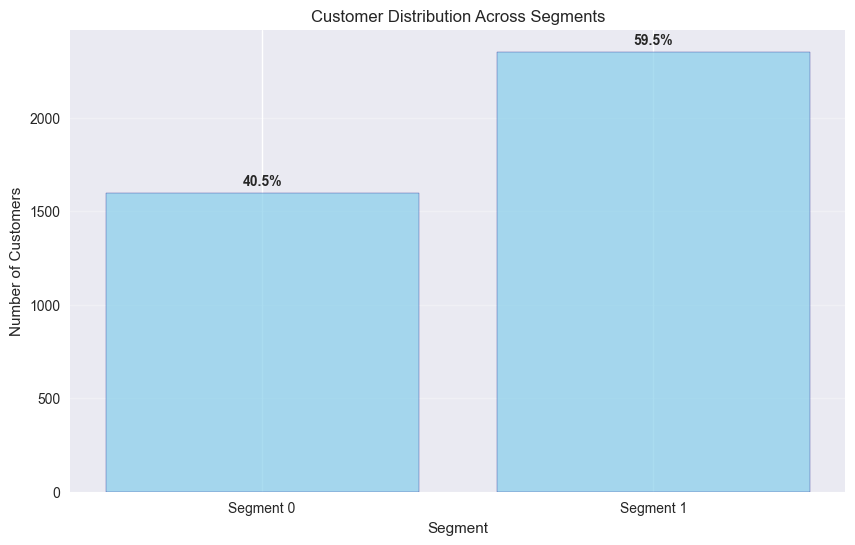

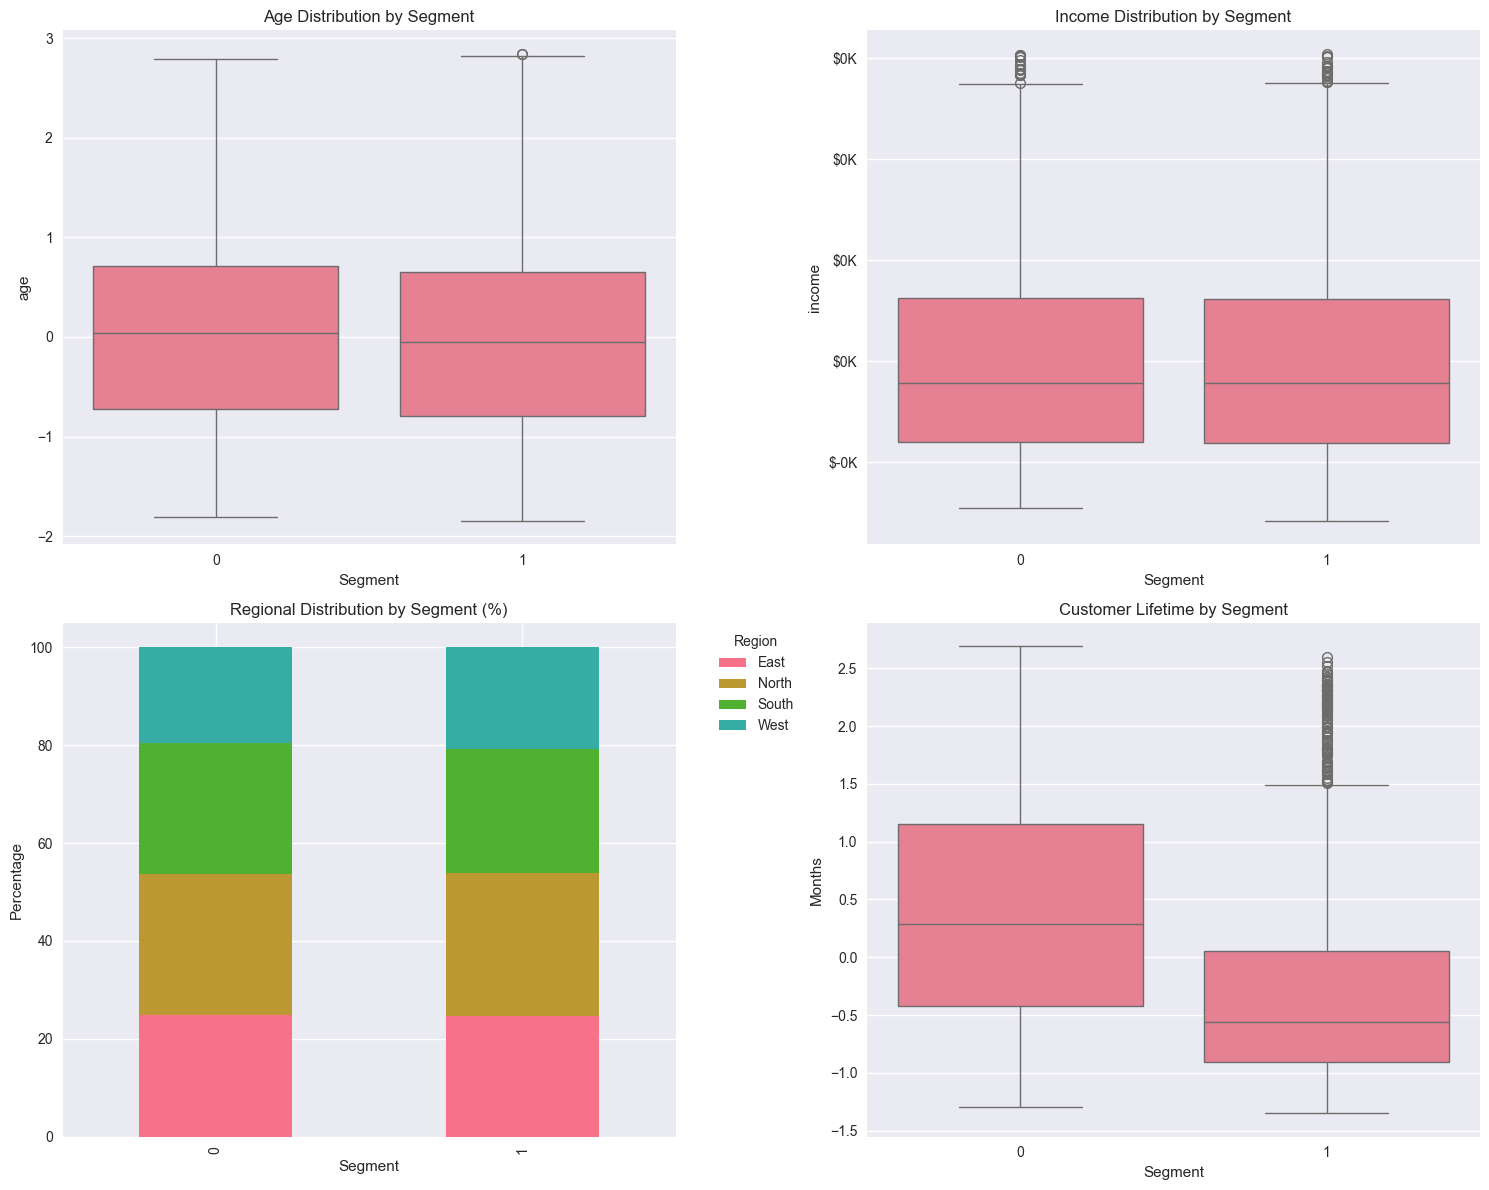

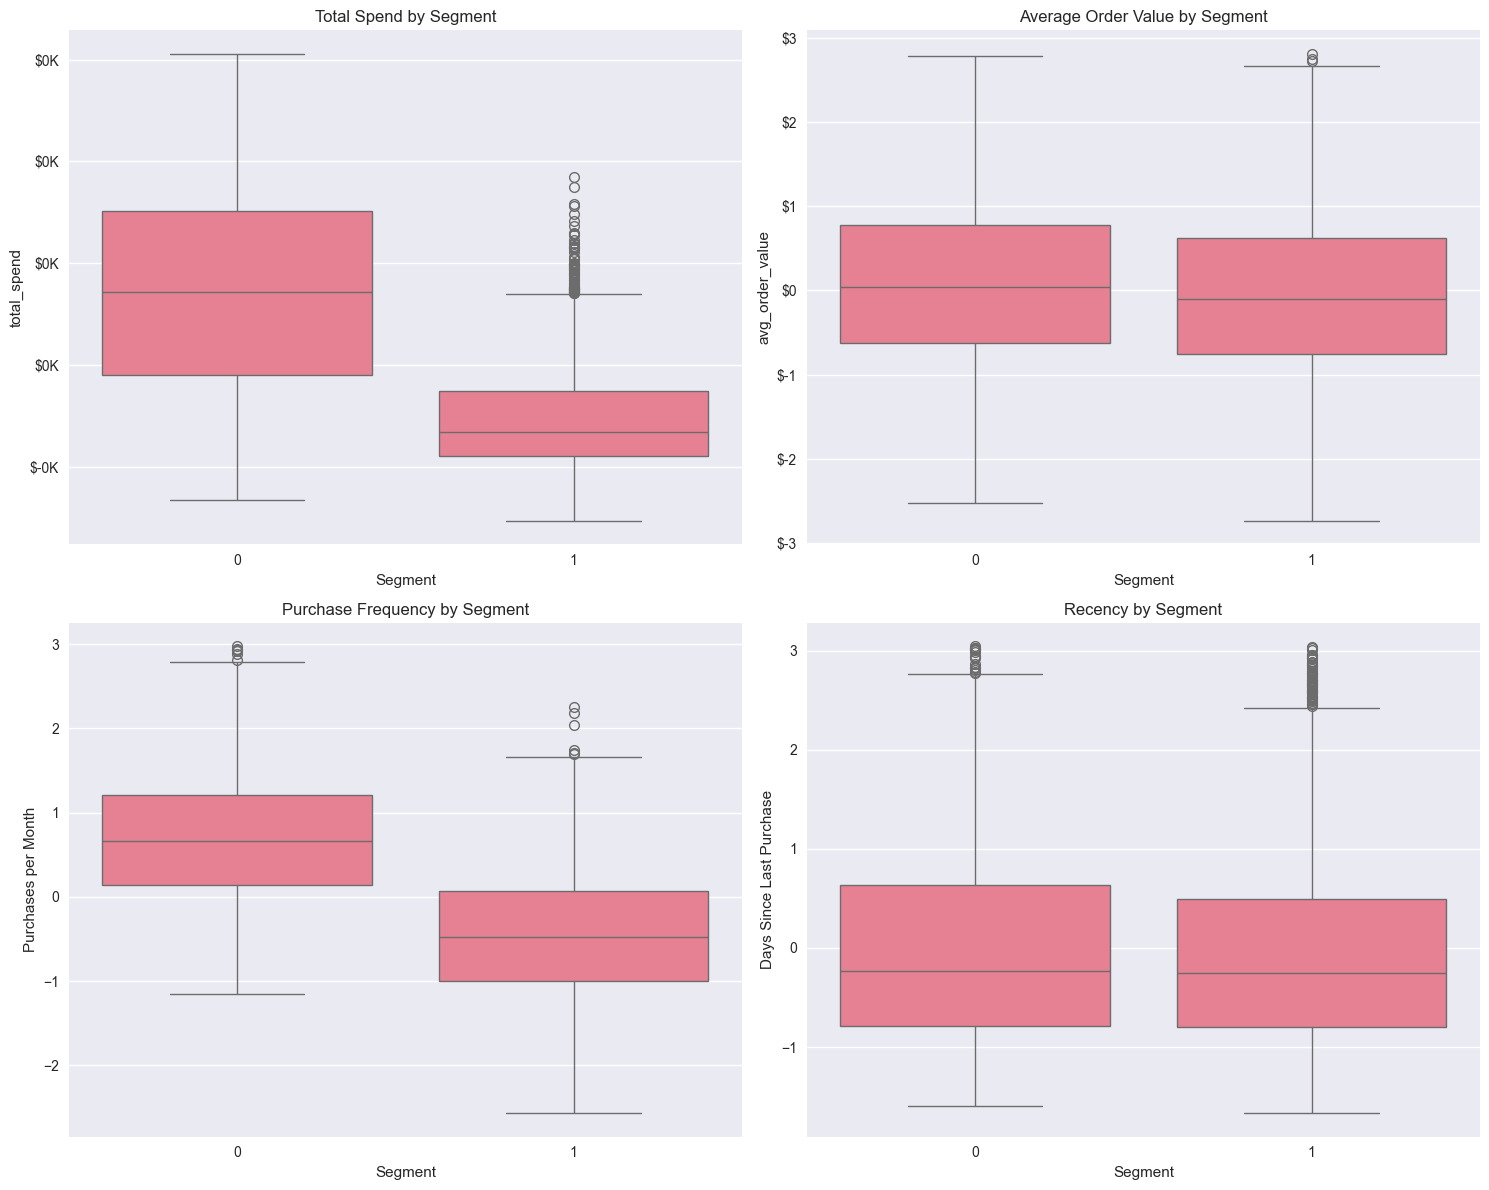

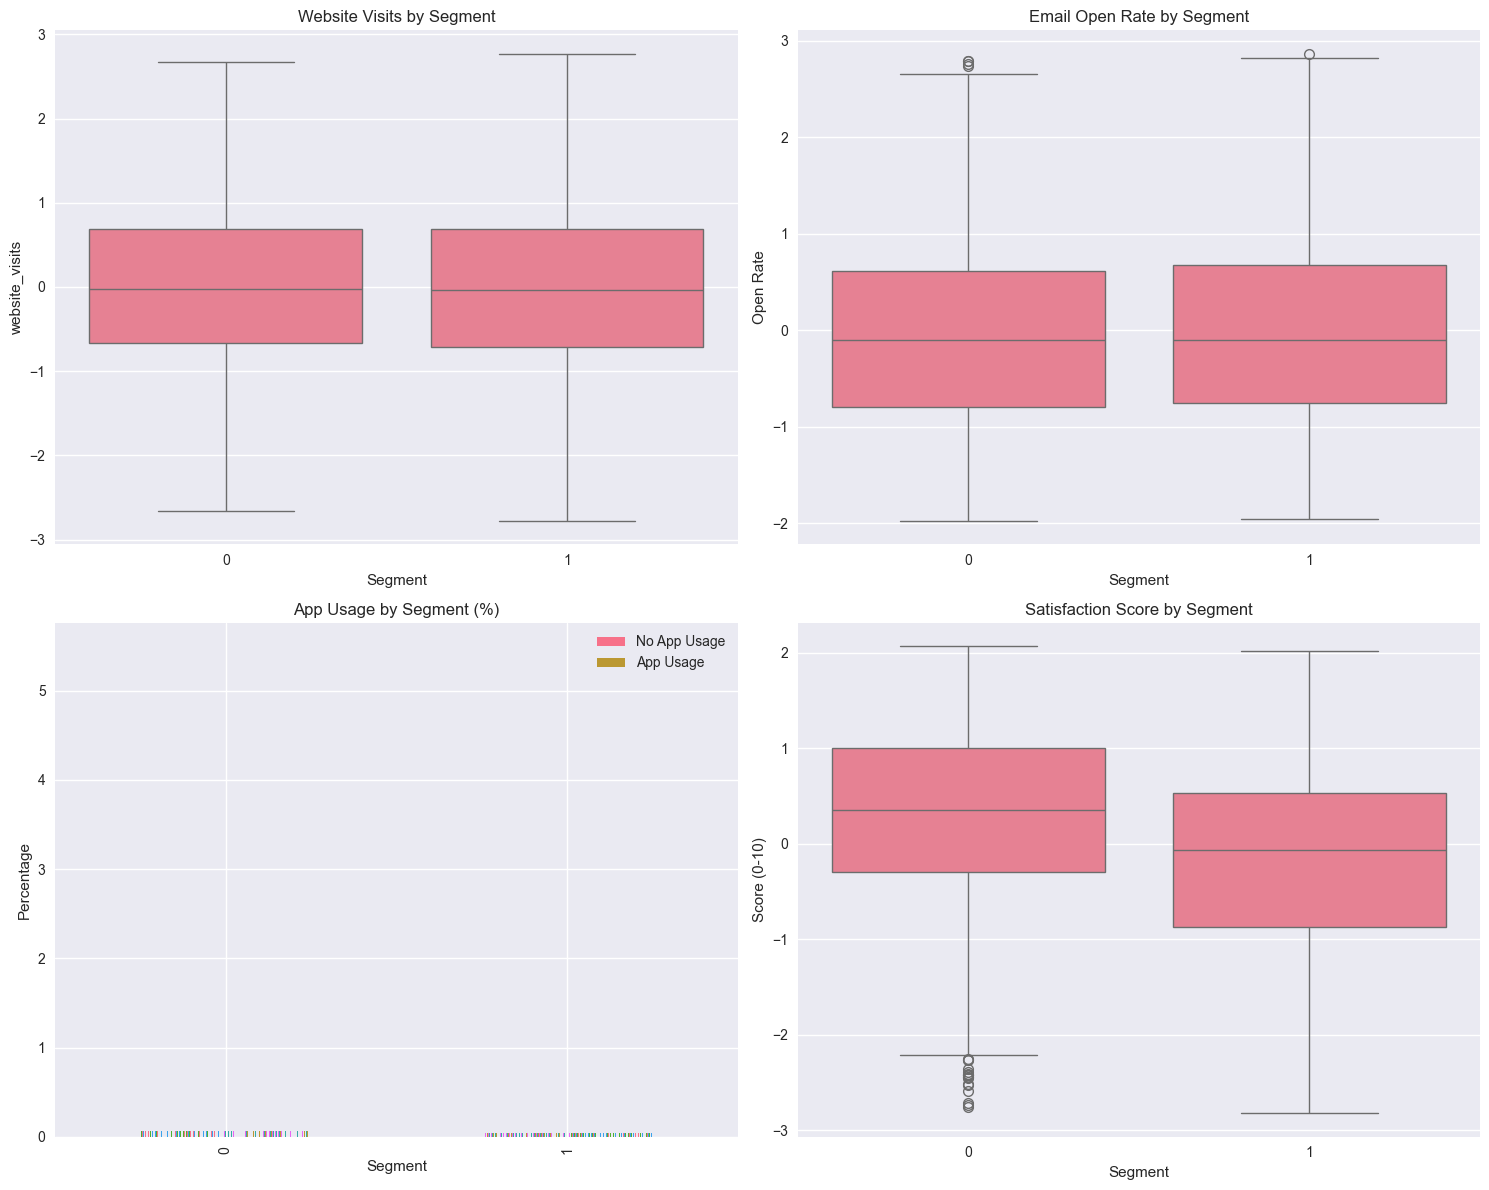

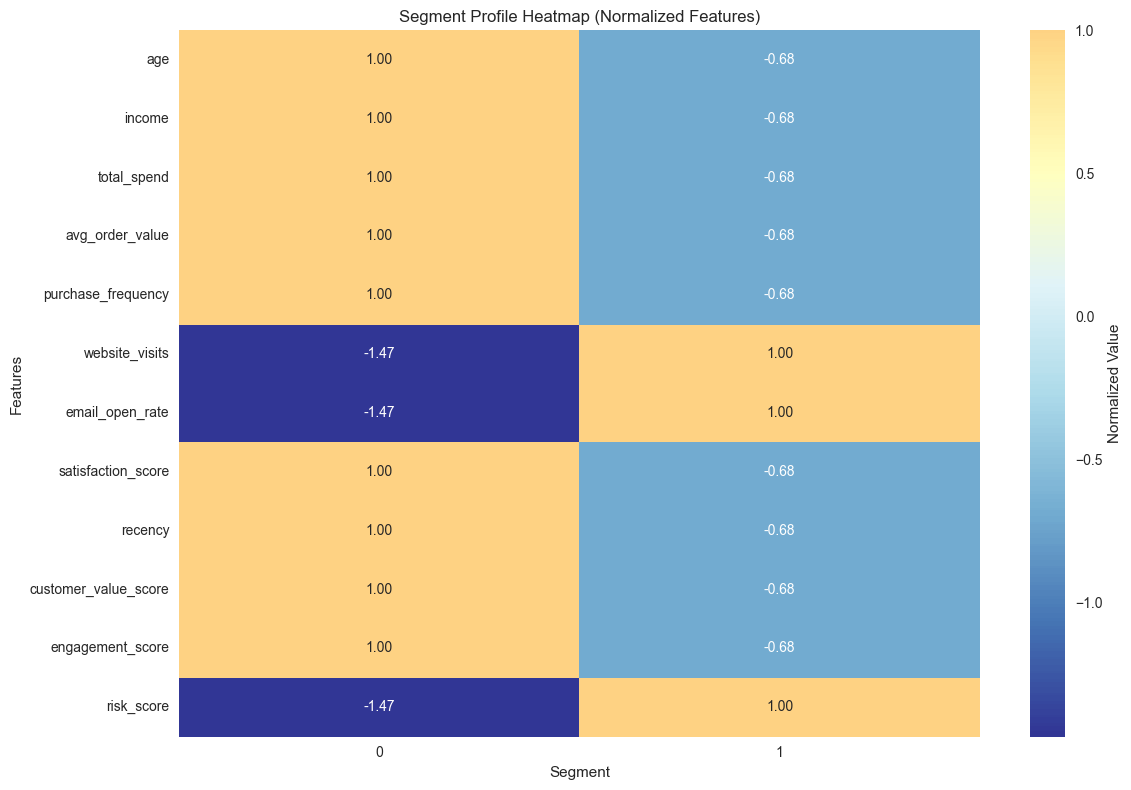

✅ Segment visualizations created!


In [19]:
# Create comprehensive visualizations
visualizer = SegmentVisualizer()

# Segment profile plots
visualizer.create_segment_profile_plots(segmented_data, cluster_labels)

print("✅ Segment visualizations created!")

## 6. Business Insights {#insights}

In [17]:
# Generate business insights for each segment
def generate_segment_insights(segment_data, segment_id):
    """Generate business insights for a segment."""
    insights = []
    
    avg_spend = segment_data['total_spend'].mean()
    avg_frequency = segment_data['purchase_frequency'].mean()
    avg_value = segment_data['avg_order_value'].mean()
    avg_age = segment_data['age'].mean()
    avg_satisfaction = segment_data['satisfaction_score'].mean()
    
    # Spending insights
    if avg_spend > segmented_data['total_spend'].quantile(0.75):
        insights.append("🔥 High-value customers with significant spending power")
    elif avg_spend < segmented_data['total_spend'].quantile(0.25):
        insights.append("💰 Price-sensitive customers requiring value propositions")
    
    # Frequency insights
    if avg_frequency > segmented_data['purchase_frequency'].median():
        insights.append("🛒 Frequent shoppers with high engagement")
    else:
        insights.append("⏱️ Occasional shoppers needing engagement strategies")
    
    # Age insights
    if avg_age < 30:
        insights.append("🌟 Young demographic, likely tech-savvy")
    elif avg_age > 50:
        insights.append("👥 Mature demographic, values reliability")
    
    # Satisfaction insights
    if avg_satisfaction > 7:
        insights.append("😊 Highly satisfied, good for referrals")
    elif avg_satisfaction < 5:
        insights.append("⚠️ Low satisfaction, needs immediate attention")
    
    return insights

# Generate insights for each segment
print("🎯 BUSINESS INSIGHTS BY SEGMENT")
print("=" * 50)

for segment_id in sorted(segmented_data['segment'].unique()):
    segment_data = segmented_data[segmented_data['segment'] == segment_id]
    size = len(segment_data)
    percentage = (size / len(segmented_data)) * 100
    
    print(f"\n📊 SEGMENT {segment_id}")
    print(f"Size: {size:,} customers ({percentage:.1f}%)")
    print(f"Avg Spend: ${segment_data['total_spend'].mean():,.0f}")
    print(f"Avg Age: {segment_data['age'].mean():.0f} years")
    print(f"Satisfaction: {segment_data['satisfaction_score'].mean():.1f}/10")
    
    insights = generate_segment_insights(segment_data, segment_id)
    print("\nKey Insights:")
    for insight in insights:
        print(f"  • {insight}")
    
    print("-" * 30)

🎯 BUSINESS INSIGHTS BY SEGMENT

📊 SEGMENT 0
Size: 1,599 customers (40.5%)
Avg Spend: $1
Avg Age: 0 years
Satisfaction: 0.3/10

Key Insights:
  • 🔥 High-value customers with significant spending power
  • 🛒 Frequent shoppers with high engagement
  • 🌟 Young demographic, likely tech-savvy
  • ⚠️ Low satisfaction, needs immediate attention
------------------------------

📊 SEGMENT 1
Size: 2,352 customers (59.5%)
Avg Spend: $-1
Avg Age: -0 years
Satisfaction: -0.2/10

Key Insights:
  • ⏱️ Occasional shoppers needing engagement strategies
  • 🌟 Young demographic, likely tech-savvy
  • ⚠️ Low satisfaction, needs immediate attention
------------------------------


In [20]:
# Summary statistics and recommendations
print("📈 OVERALL SEGMENTATION SUMMARY")
print("=" * 40)
print(f"Total Customers Analyzed: {len(segmented_data):,}")
print(f"Number of Segments: {len(set(cluster_labels))}")
print(f"Segmentation Quality (Silhouette Score): {clustering_model.metrics['silhouette_score']:.3f}")

# Top performing segment
segment_value = segmented_data.groupby('segment')['total_spend'].mean()
top_segment = segment_value.idxmax()
print(f"\n🏆 Highest Value Segment: Segment {top_segment}")
print(f"   Average Spend: ${segment_value[top_segment]:,.0f}")

# Largest segment
largest_segment = segmented_data['segment'].value_counts().idxmax()
largest_size = segmented_data['segment'].value_counts().max()
print(f"\n👥 Largest Segment: Segment {largest_segment}")
print(f"   Size: {largest_size:,} customers ({largest_size/len(segmented_data)*100:.1f}%)")

print("\n✅ Segmentation analysis completed successfully!")

📈 OVERALL SEGMENTATION SUMMARY
Total Customers Analyzed: 3,951
Number of Segments: 2
Segmentation Quality (Silhouette Score): 0.112

🏆 Highest Value Segment: Segment 0
   Average Spend: $1

👥 Largest Segment: Segment 1
   Size: 2,352 customers (59.5%)

✅ Segmentation analysis completed successfully!
